In [ ]:
!nvidia-smi

Sat Jun 27 10:06:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install catboost
!pip install lightgbm
!pip install pycaret

In [ ]:
import os
import pickle
import warnings
import numpy as np
import pycaret as pk
import pandas as pd
import seaborn as sb
from pylab import rcParams
from datetime import datetime
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12,5
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 20
pd.options.display.max_rows = 100
# pd.options.display.float_format = "{:,.3f}".format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# !unzip '/content/drive/My Drive/ZINDI/UmojaHack Rwanda/data.zip'

In [ ]:
train = pd.read_csv('/content/data/Train.csv')
test = pd.read_csv('/content/data/Test.csv')
sample = pd.read_csv('/content/data/SampleSubmission.csv')

print(f'Train size of {train.shape}')
print(f'Train size of {test.shape}')

Train size of (2154048, 19)
Train size of (380127, 18)


In [ ]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


## **DATA PREPROCESSING**

**Filling Missing Values**

In [ ]:
train.isnull().sum()/len(train)*100

user_id            0.000000
REGION            39.428044
TENURE             0.000000
MONTANT           35.131018
FREQUENCE_RECH    35.131018
REVENUE           33.706213
ARPU_SEGMENT      33.706213
FREQUENCE         33.706213
DATA_VOLUME       49.229776
ON_NET            36.520774
ORANGE            41.561191
TIGO              59.887988
ZONE1             92.120835
ZONE2             93.648052
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.902223
FREQ_TOP_PACK     41.902223
CHURN              0.000000
dtype: float64

In [ ]:
test.isnull().sum()/len(test)*100

user_id            0.000000
REGION            39.388941
TENURE             0.000000
MONTANT           35.002775
FREQUENCE_RECH    35.002775
REVENUE           33.508012
ARPU_SEGMENT      33.508012
FREQUENCE         33.508012
DATA_VOLUME       49.204608
ON_NET            36.438874
ORANGE            41.362492
TIGO              59.717147
ZONE1             92.144468
ZONE2             93.666327
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.769987
FREQ_TOP_PACK     41.769987
dtype: float64

In [ ]:
# drop ZONE1,ZONE2 and MRG
train.drop(['ZONE1','ZONE2','MRG'],axis=1,inplace=True)
test.drop(['ZONE1','ZONE2','MRG'],axis=1,inplace=True)

In [ ]:
cols = train.columns
cat_features = []
num_features = []
for i in cols:
  if train[i].dtype == 'O':
    cat_features.append(i)
  else:
    num_features.append(i)
print(f'The categorical features are: \n{cat_features}')
print('')
print(f'The numeric features are: \n{num_features}')


The categorical features are: 
['user_id', 'REGION', 'TENURE', 'TOP_PACK']

The numeric features are: 
['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']


In [ ]:
# impute missing values with -999
train[num_features[:-1]] = train[num_features[:-1]].apply(lambda x: x.fillna(-999))
test[num_features[:-1]] = test[num_features[:-1]].apply(lambda x: x.fillna(-999))

# impute missing value in Region with 'unknown'
train_reg_missing = train[train['REGION'].isnull()].index.tolist()
train['REGION'].loc[train_reg_missing] = 'UNKNOWN'

test_reg_missing = test[test['REGION'].isnull()].index.tolist()
test['REGION'].loc[test_reg_missing] = 'UNKNOWN'

In [ ]:
train.isnull().sum()

user_id                0
REGION                 0
TENURE                 0
MONTANT                0
FREQUENCE_RECH         0
REVENUE                0
ARPU_SEGMENT           0
FREQUENCE              0
DATA_VOLUME            0
ON_NET                 0
ORANGE                 0
TIGO                   0
REGULARITY             0
TOP_PACK          902594
FREQ_TOP_PACK          0
CHURN                  0
dtype: int64

In [ ]:
test.isnull().sum()

user_id                0
REGION                 0
TENURE                 0
MONTANT                0
FREQUENCE_RECH         0
REVENUE                0
ARPU_SEGMENT           0
FREQUENCE              0
DATA_VOLUME            0
ON_NET                 0
ORANGE                 0
TIGO                   0
REGULARITY             0
TOP_PACK          158779
FREQ_TOP_PACK          0
dtype: int64

In [ ]:
# unique counts of tenure
train['TOP_PACK'] = train['TOP_PACK'].fillna(train['TOP_PACK'].mode()[0])
test['TOP_PACK'] = test['TOP_PACK'].fillna(test['TOP_PACK'].mode()[0])

In [ ]:
train.drop('user_id',axis=1,inplace = True)
train.to_csv('Cleaned_Train',index=False)
train.isnull().sum()

REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

In [ ]:
test.to_csv('Cleaned_Test',index=False)
test.isnull().sum()

user_id           0
REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64

**Remove Outliers**

In [ ]:
# Q1 = train.quantile(0.25)
# Q3 = train.quantile(0.75)
# IQR = Q3 - Q1
# IQR
# train = train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
train.shape

(2154048, 15)

In [ ]:
train['CHURN'].value_counts()

0    1750062
1     403986
Name: CHURN, dtype: int64

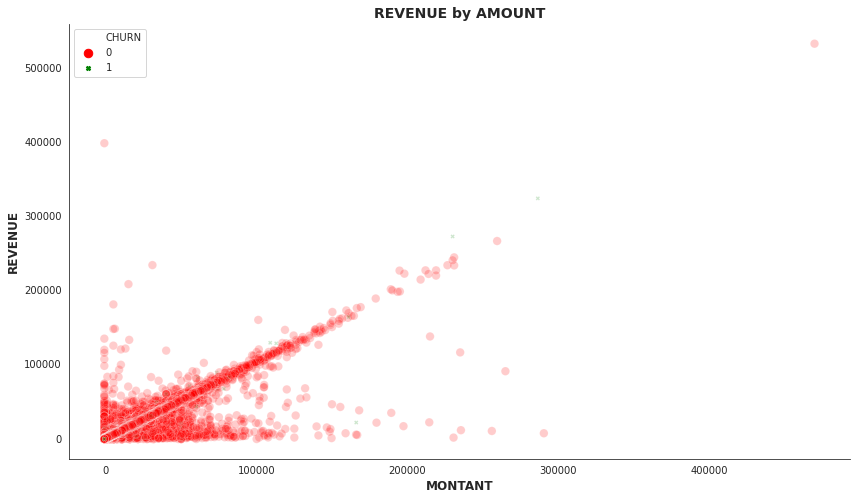

In [ ]:
# Set initial plot options
sb.set_style('white')
plt.figure(figsize = (14, 8))

# Create scatterplot
sb.scatterplot(x = "MONTANT",
                y = "REVENUE",
                # Group by and change dot style and  by CHURN
                hue = "CHURN",
                size = "CHURN",
                style = "CHURN",
                data = train,
                # Change color of hue categories
                palette = ["r", "g"],
                alpha = 0.2)

# Despine plot
sb.despine()
# Final formatting touches
plt.xlabel("MONTANT", fontsize = 12, fontweight = "semibold")
plt.ylabel("REVENUE", fontsize = 12, fontweight = "semibold")
plt.title("REVENUE by AMOUNT", fontsize = 14, fontweight = "semibold")
plt.show()

In [ ]:
outlier = train[train['MONTANT'] > 250000.0].index.tolist()
train = train.drop(outlier)
train.shape

(2154042, 15)

In [ ]:
# # Encoding categorical features
# from sklearn.preprocessing import LabelEncoder,StandardScaler
# le = LabelEncoder()
# for i in cat_features[1:]:
#     train[i] = le.fit_transform(train[i])
# train.head()

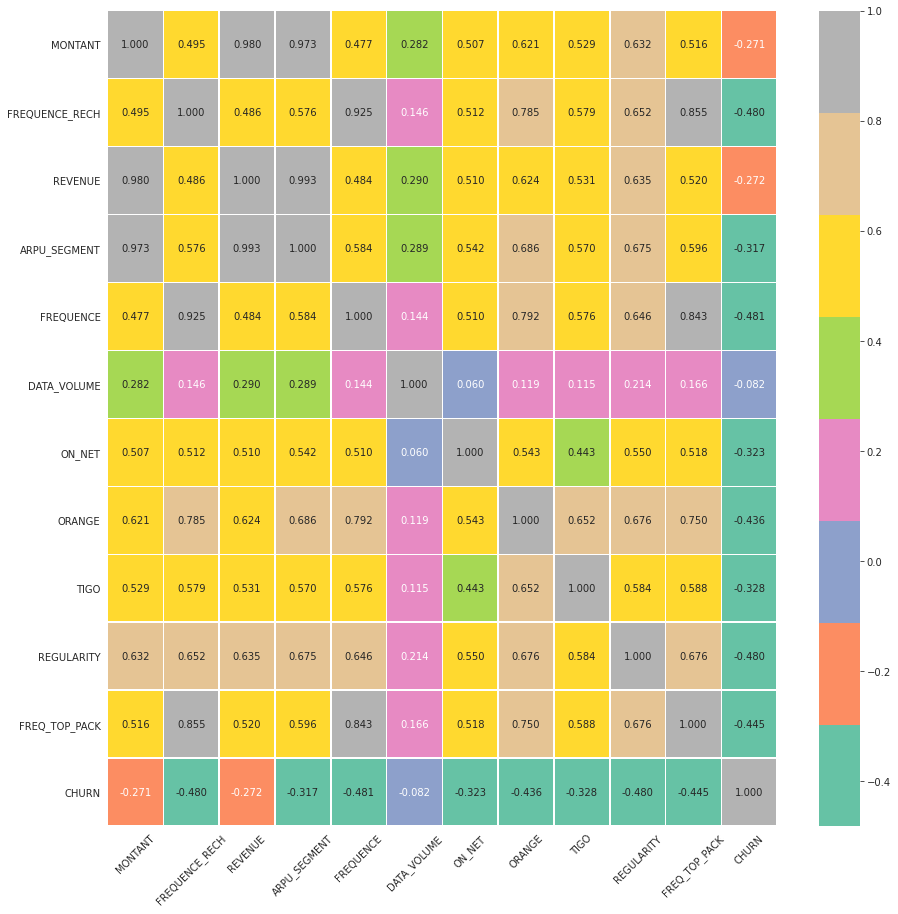

In [ ]:
dfcor = train.corr()
fig = plt.figure(figsize=(15,15))
ax = sb.heatmap(dfcor,annot = True, fmt = ".3f", linewidths=0.5,cmap='Set2')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
count_no_churn = (train['CHURN'] == 0).sum()
print("Number of customers who didn't churn:",count_no_churn)
count_yes_churn = (train['CHURN']==1).sum()
print("Number of customers who churnes:",count_yes_churn)
pct_of_no_churn = count_no_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who didn't churn:", pct_of_no_churn*100)
pct_of_yes_churn = count_yes_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who churned:", pct_of_yes_churn*100)

Number of customers who didn't churn: 1750057
Number of customers who churnes: 403985
percentage of customers who didn't churn: 81.2452589132431
percentage of customers who churned: 18.754741086756894


Shape of X: (2154042, 14)
Shape of y: (2154042, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score,log_loss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,Pool, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel


RANDOM_SEED = 380    # Set a random seed for reproducibility!

In [ ]:
numeric_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT','FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO','REGULARITY', 'FREQ_TOP_PACK']
categorical_cols = ['REGION', 'TENURE', 'TOP_PACK']

In [ ]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([('standard_scaler', StandardScaler()),('simple_imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator = True))])

categorical_preprocessing_steps = Pipeline([('simple_imputer', SimpleImputer(strategy='constant', fill_value='Missing', add_indicator = True)),('onehot', OneHotEncoder(handle_unknown='ignore'))])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(transformers = [("numeric", numeric_preprocessing_steps, numeric_cols),('categorical', categorical_preprocessing_steps, categorical_cols)],remainder = "drop")

In [ ]:
from sklearn.model_selection import train_test_split
X = train.loc[:, train.columns != 'CHURN']
y = train.loc[:, train.columns == 'CHURN']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,stratify=y,random_state=RANDOM_SEED )
print('')

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Shape of X: (2154042, 14)
Shape of y: (2154042, 1)

Number transactions X_train dataset:  (1723233, 14)
Number transactions y_train dataset:  (1723233, 1)
Number transactions X_test dataset:  (430809, 14)
Number transactions y_test dataset:  (430809, 1)


## **BUILDING MODELS**

**Logistic Regression CV**

In [ ]:
%%time
train_pipeline = Pipeline([("preprocessor", preprocessor),("estimator", LogisticRegressionCV(random_state = 100)),])
# Train model
train_pipeline.fit(X_train, y_train)
# Predict on evaluation set
preds = train_pipeline.predict_proba(X_test)
print('Logistic Regresssion log loss: {}'.format(log_loss(y_test, preds[:, 1])))

Logistic Regresssion log loss: 0.26121012805174404
CPU times: user 15min 6s, sys: 3.69 s, total: 15min 9s
Wall time: 15min 10s


In [ ]:
%%time
train_pipeline.fit(X,y)
test_probas = train_pipeline.predict_proba(test.drop('user_id', axis = 1))
# Save predictions to submission data frame
sample["CHURN"] = test_probas[:, 1]
sample.to_csv('HIMF_logcv.csv', index=False)

CPU times: user 18min 52s, sys: 5.23 s, total: 18min 57s
Wall time: 18min 58s


**Random Forest**

In [ ]:
%%time
train_pipeline = Pipeline([("preprocessor", preprocessor),("estimator", RandomForestClassifier(max_features='auto', n_estimators= 800, max_depth=11, criterion='entropy',random_state = 100)),])
# Train model
train_pipeline.fit(X_train, y_train)
# Predict on evaluation set
preds = train_pipeline.predict_proba(X_test)
print('Random Forest log loss: {}'.format(log_loss(y_test, preds[:, 1])))

In [ ]:
%%time
full_pipeline.fit(X,y)
test_probas = full_pipeline.predict_proba(test.drop('user_id', axis = 1))
# Save predictions to submission data frame
sample["CHURN"] = test_probas[:, 1]
sample.to_csv('HIMF_ranfort.csv', index=False)

In [ ]:
sel = SelectFromModel(RandomForestClassifier(random_state=11, max_features='auto', n_estimators= 800, max_depth=11, criterion='entropy'))
sel.fit(X_train_smote, y_train_smote)
selected_feat = X.columns[(sel.get_support())]
selected_feat

**Decision Tree Classifier**

In [ ]:
%%time
train_pipeline = Pipeline([("preprocessor", preprocessor),("estimator", RandomForestClassifier(max_features='auto', n_estimators= 800, max_depth=11, criterion='entropy',random_state = 100)),])
# Train model
train_pipeline.fit(X_train, y_train)
# Predict on evaluation set
preds = train_pipeline.predict_proba(X_test)
print('Random Forest log loss: {}'.format(log_loss(y_test, preds[:, 1])))

In [ ]:
%%time
full_pipeline.fit(X,y)
test_probas = full_pipeline.predict_proba(test.drop('user_id', axis = 1))
# Save predictions to submission data frame
sample["CHURN"] = test_probas[:, 1]
sample.to_csv('HIMF_ranfort.csv', index=False)

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=380)
# X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

# print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

# print("After OverSampling, counts of label '1': {}".format(len(y_train_smote==1)))
# print("After OverSampling, counts of label '0': {}".format(len(y_train_smote==0)))

In [ ]:
X_train_smote[1]

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100, 200,300,400,500,600,700,800,1000],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [2,4,5,6,7,8,9,11,13,15],
#     'criterion' :['gini', 'entropy']
# }

# rfc=RandomForestClassifier(random_state=0)
# start_time = timer(None)
# rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# rfc.fit(X_train_smote, y_train_smote)
# best_params = rfc.best_params_
# timer(start_time)

In [ ]:
# train random forest model
rfc_best=RandomForestClassifier(random_state=11, max_features='auto', n_estimators= 800, max_depth=11, criterion='entropy')
rfc_best.fit(X_train_smote, y_train_smote)
y_pred_rfc = rfc_best.predict(X_test)
print('')
print(f'The log loss for Random Forest is : {log_loss(y_test, y_pred_rfc)}')
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_rfc,target_names=target_names))

plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, y_pred_rfc)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='Set3', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Logistic Regression CV');

# plotting feature importance
plt.figure(figsize=(12,8))
feat_importances = pd.Series(rfc_best.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh',cmap='bwr')
plt.title('Feature Importance from Random Forest Model')

plt.show()

**Feature Selection Using RandomForest**

In [ ]:
sel = SelectFromModel(RandomForestClassifier(random_state=11, max_features='auto', n_estimators= 800, max_depth=11, criterion='entropy'))
sel.fit(X_train_smote, y_train_smote)
selected_feat = X.columns[(sel.get_support())]
X1 = X[selected_feat]
X1.head()

It can be observed from above that the features have almost neutral relationship with the target ie churn

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,Pool, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel


In [ ]:
# timer to check on time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

**Use Random Forest Feature Importance to Select Features**

In [ ]:
models = [('knn', KNeighborsClassifier),
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
start_time = timer(None)
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params,scoring=make_scorer(accuracy_score))
    grid.fit(X_train_smote, y_train_smote)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid
timer(start_time)

**Train Models With Default Parameters**

In [ ]:
randstate = 380
models = [LogisticRegression(random_state = randstate),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(random_state = randstate,probability = True),
          BaggingClassifier(random_state = randstate),
          DecisionTreeClassifier(random_state = randstate),
          RandomForestClassifier(random_state = randstate),
          GradientBoostingClassifier(random_state = randstate),
          XGBClassifier(random_state = randstate),
          MLPClassifier(random_state = randstate),
          CatBoostClassifier(random_state = randstate,verbose = False)]

names = ["LogisticRegression",
         "GaussianNB",
         "KNN",
         "SVC",
         "Bagging",
         "DecisionTree",
         "Random_Forest",
         "GBM",
         "XGBoost",
         "Art.Neural_Network",
         "CatBoost"]

print('Models Performances With Default Parameters On Validation Set:', end = "\n\n")
start_time = timer(None)
for name, model in zip(names, models):
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    print(name,':',"%.3f" % accuracy_score(y_pred, y_test))
timer(start_time)

**10-Fold Cross-Validate Models On Models With Default Parameters**

In [ ]:
# all_train = np.concatenate((X_train_smote,X_test),axis = 0)
results = []
print('10 fold Cross validation accuracy and std of the default models for the train data:', end = "\n\n")
start_time = timer(None)
for name, model in zip(names, models):
    kfold = KFold(n_splits=10, random_state=randstate)
    cv_results = cross_val_score(model, X, y, cv = kfold, scoring = "accuracy")
    results.append(cv_results)
    print("{}: {} ({})".format(name, "%.3f" % cv_results.mean() ,"%.3f" %  cv_results.std()))
timer(start_time)

**Tune Model Parameters Using Gridsearch & Cross-Validation**

In [ ]:
# Possible hyper parameters
logreg_params= {"C":np.logspace(-1, 1, 10),"penalty": ["l1","l2"], "solver":['lbfgs', 'liblinear', 'sag', 'saga'], "max_iter":[1000]}

NB_params = {'var_smoothing': np.logspace(0,-9, num=100)}

knn_params= {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),"weights": ["uniform","distance"],"metric":["euclidean","manhattan"]}

svc_params= {"kernel" : ["rbf"],"gamma": [0.001, 0.01, 0.1, 1, 5, 10 ,50 ,100],"C": [1,10,50,100,200,300,1000]}

bag_params={"n_estimators":[50,120,300]}

dtree_params = {"min_samples_split" : range(10,500,20),"max_depth": range(1,20,2)}

rf_params = {"max_features": ["log2","auto","sqrt"],"min_samples_split":[2,3,5],"min_samples_leaf":[1,3,5],"bootstrap":[True,False],"n_estimators":[50,100,150],"criterion":["gini","entropy"]}

gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],"n_estimators": [100,500,100],"max_depth": [3,5,10],"min_samples_split": [2,5,10]}

xgb_params ={'n_estimators': [50, 100, 200],'subsample': [ 0.6, 0.8, 1.0],'max_depth': [1,2,3,4],'learning_rate': [0.1,0.2, 0.3, 0.4, 0.5],"min_samples_split": [1,2,4,6]}

mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],"hidden_layer_sizes": [(10,10,10),(100,100,100),(100,100),(3,5), (5, 3)],"solver" : ["lbfgs","adam","sgd"],"max_iter":[1000]}

catb_params =  {'depth':[2, 3, 4],'loss_function': ['Logloss', 'CrossEntropy'],'l2_leaf_reg':np.arange(2,31)}

model_params = [logreg_params,NB_params,knn_params,svc_params,bag_params,dtree_params,rf_params,gbm_params, xgb_params,mlpc_params,catb_params]

In [ ]:
%time
# Tuning by Cross Validation
cv_result = {}
best_estimators = {}
for name, model, param in zip(names, models,model_params):
  # with timer(">Model tuning"):
  start_time = timer(None)
  clf = GridSearchCV(model, param_grid = param, cv =5, scoring = "accuracy", n_jobs = -1,verbose = False)# scoring = make_scorer(log_loss)
  clf.fit(X_train_smote,y_train_smote)
  cv_result[name] = clf.best_score_
  best_estimators[name] = clf.best_estimator_
  print(name,'cross validation accuracy : %.3f'%cv_result[name])
  timer(start_time)



**Ensembling Best 5 Models**

In [ ]:
n = 5
accu = sorted(cv_result, reverse = True, key = lambda k:cv_result[k])[:n]
best_n = [[k,v] for k,v in best_estimators.items() if k in accu]

In [ ]:
# Ensembling Best 5 Score
votingC = VotingClassifier(estimators = best_n , voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train_smote, y_train_smote)
print(accuracy_score(votingC.predict(X_test),y_test))

In [ ]:
# save the model so created above into a picle.
pickle.dump(model, open('votedmodel.pkl', 'wb'))

**Feedforward Neural Network**

In [ ]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers.core import Dropout
from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling1D

In [ ]:
lsize = 128
model = Sequential()
model.add(Dense(lsize, input_dim=int(X_train_smote.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(int(lsize/2),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit the model
history = model.fit(X_train_smote, y_train_smote, epochs=15, batch_size=512,validation_data=(X_test,y_test)),#512, validation_split=0.2, verbose=1)


In [ ]:
# # submission
# predictions = model.predict(X_test)
# test['is_churn'] = predictions.clip(0.+1e-15, 1-1e-15)
# test[['msno','is_churn']].to_csv('submission_NN.csv', index=False)

**Logistic Regression**

In [ ]:
%time
param_grid = {'C': np.logspace(-3,6, 12)}
logreg = LogisticRegression()
start_time = timer(None)
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)
best_model = logreg_cv.fit(X_train_smote, y_train_smote)
print(best_model.best_score_)
print(best_model.best_params_)
timer(start_time)

In [ ]:
best_lr = LogisticRegression(C=0.2848035868435802)
best_lr.fit(X_train_smote, y_train_smote)
y_pred_lr = best_lr.predict(X_test)

In [ ]:
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_lr,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, y_pred_lr)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='Set2', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Logistic Regression CV');

# # plotting feature importance
# plt.figure(figsize=(12,8))
# feat_importances = pd.Series(best_lr.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).sort_values().plot(kind='barh')
# plt.title('Feature Importance from Logistic Regression')

plt.show()

**KNN**

In [ ]:
%time
k_range = list(range(1, 100))
param_grid = dict(n_neighbors=k_range)
knn = KNN()
start_time = timer(None)
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
best_model = knn_cv.fit(X_train_smote, y_train_smote)
print(best_model.best_score_)
print(best_model.best_params_)
timer(start_time)

In [ ]:
best_knn = KNN(n_neighbors=1)
best_knn.fit(X_train_smote, y_train_smote)
y_pred_knn = best_knn.predict(X_test)

In [ ]:
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_knn,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, y_pred_knn)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='Set2', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix K-Neighbor Classifer');

# # plotting feature importance
# plt.figure(figsize=(12,8))
# feat_importances = pd.Series(best_knn.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).sort_values().plot(kind='barh')
# plt.title('Feature Importance from Logistic Regression')

plt.show()

**SVM**

In [ ]:
%time
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
# kernels = ['linear','rbf']
param_grid = {'C': Cs, 'gamma' : gammas}
start_time = timer(None)
svm_cv = GridSearchCV(SVC(),param_grid = param_grid , cv = 5)
svm_cv.fit(X_train_smote, y_train_smote)
print(svm_cv.best_score_)
print(svm_cv.best_params_)
timer(start_time)

In [ ]:
best_svm= SVC(kernel='rbf', gamma = 0.001,C= 10)
best_svm.fit(X_train_smote, y_train_smote)
y_pred_svm = best_svm.predict(X_test)

In [ ]:
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_svm,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, y_pred_svm)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='Set1', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Support Vector Classifer');

# plotting feature importance
# plt.figure(figsize=(12,8))
# feat_importances = pd.Series(best_svm.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).sort_values().plot(kind='barh')
# plt.title('Feature Importance from Logistic Regression')

# plt.show()

**Decision Tree Classifier**

In [ ]:
# %time
# depths = np.arange(1, 21)
# num_leafs = [1, 5, 10, 20, 50, 100]
# param_grid = {'depths':depths,'num_leafs':num_leafs }
# start_time = timer(None)
# dtc = DecisionTreeClassifier()
# dtc_cv = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy')
# best_model = dtc_cv.fit(X_train_smote, y_train_smote)
# print(best_model.best_score_)
# print(best_model.best_params_)
# timer(start_time)

In [ ]:
best_dtc = DecisionTreeClassifier()
best_dtc.fit(X_train_smote, y_train_smote)
y_pred_dtc = best_dtc.predict(X_test)

In [ ]:
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_dtc,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, y_pred_dtc)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='bwr', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Decision Tree Classifier');

plt.show()

**XGBClassifier**

In [ ]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]

}

xgb = XGBClassifier()
xgb_search = RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)
start_time = timer(None)
xgb_search.fit(x_train,y_train)
timer(start_time)

In [ ]:
xgb_search.best_params_

In [ ]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

best_xgb.fit(X_train_smote, y_train_smote)
xgb_pred = best_xgb.predict(X_test)

In [ ]:
target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, xgb_pred,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, xgb_pred)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='bwr', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix XGB Classifier');

plt.show()

**Catboost Classifier**

In [ ]:
# train_data = Pool(data = x_train[features], label = y_train, cat_features = cat_cols)
# test_data = Pool(data = x_test[features],cat_features = cat_cols)

train_data = Pool(data = X_train_smote, label = y_train_smote)
test_data = Pool(data = X_test)

params = {
    'iterations':1000,
    'custom_metric':'Accuracy',
    'loss_function':'CrossEntropy'
}

cv_results = cv(train_data, params, fold_count=5,plot=True,verbose=False)

In [ ]:
start_time = timer(None)
model = CatBoostClassifier(**params)
model.fit(train_data, plot =True,verbose=False)
timer(start_time)

In [ ]:
cat_pred = model.predict(test_data)

target_names = ['Not Churned', 'Churned']
print(classification_report(y_test, cat_pred,target_names=target_names))
plt.figure(figsize=(10,4))
cm =confusion_matrix(y_test, cat_pred)
ax= plt.subplot(122)
sb.heatmap(cm,annot=True,fmt='.0f',cmap='bwr', ax = ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Catboost Classifier');

plt.show()